In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing the required libraries

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Function to unpickle the dataset

In [3]:
def load_data(folder_path):

    # Initializing the variables
    train = dict()
    test = dict()
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    # Iterate through all files that we want, train and test
    # Train is separated into batches
    for filename in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, filename)):
            
            # The train data
            if 'data_batch' in filename:
                print('Handing file: %s' % filename)
                
                # Open the file
                with open(folder_path + '/' + filename, 'rb') as fo:
                    data = pickle.load(fo, encoding='bytes')

                if 'data' not in train:
                    train['data'] = data[b'data']
                    train['labels'] = np.array(data[b'labels'])
                else:
                    train['data'] = np.concatenate((train['data'], data[b'data']))
                    train['labels'] = np.concatenate((train['labels'], data[b'labels']))
            # The test data
            elif 'test_batch' in filename:
                print('Handing file: %s' % filename)
                
                # Open the file
                with open(folder_path + '/' + filename, 'rb') as fo:
                    data = pickle.load(fo, encoding='bytes')
                
                test['data'] = data[b'data']
                test['labels'] = data[b'labels']
    
    # Manipulate the data to the proper format
    for image in train['data']:
        x_train.append(np.transpose(np.reshape(image,(3, 32,32)), (1,2,0)))
    y_train = [label for label in train['labels']]
    
    for image in test['data']:
        x_test.append(np.transpose(np.reshape(image,(3, 32,32)), (1,2,0)))
    y_test = [label for label in test['labels']]
    
    # Transform the data to np array format
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    return (x_train, y_train), (x_test, y_test)

# Loading the data

In [5]:
(x_train, y_train), (x_test, y_test) = load_data(os.getcwd() + '/drive/MyDrive/AIBD Assignment 2/data') #use the folder/directory path here

Handing file: test_batch
Handing file: data_batch_3
Handing file: data_batch_2
Handing file: data_batch_5
Handing file: data_batch_1
Handing file: data_batch_4


In [21]:
# y values are integers from 0-9, each corresponding to the index of the following list
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Looking at the images in the dataset

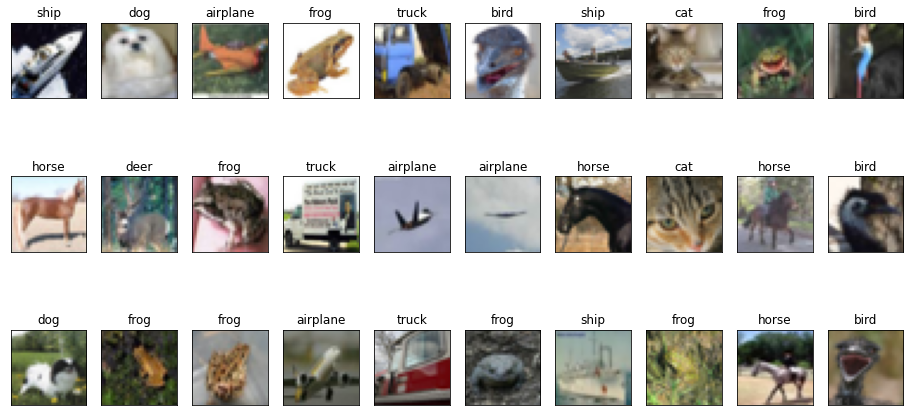

In [9]:
fig, axes = plt.subplots(ncols=10, nrows=3, figsize=(16, 8))
index = 0
for i in range(3):
    for j in range(10):
        axes[i,j].set_title(labels[y_train[index]])
        axes[i,j].imshow(x_train[index])
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1

# Normalizaing and reshaping the dataset for 3D CNN

In [10]:
#normalization
x_train = x_train/255
x_test = x_test/255
#reshaping
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], x_test.shape[3]))
print(x_train.shape)
print(x_test.shape)

(50000, 1, 32, 32, 3)
(10000, 1, 32, 32, 3)


# NumPy to Torch Conversion of data

In [11]:
train_x = torch.from_numpy(x_train).float()
train_y = torch.from_numpy(y_train).long()
test_x = torch.from_numpy(x_test).float()
test_y = torch.from_numpy(y_test).long()

# CNN Class

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 64, 3, 2, 1)
        self.conv2 = nn.Conv3d(64, 10, 3,2,1)
        self.conv3 = nn.Conv3d(10,10,3,2,1)
        #To ensure the depth dimension is preserved during convolution we take the third maxpool dimension as 1 instead of 2
        self.pool1 = nn.MaxPool3d((2,2,1), stride = (2,2,1))
        self.pool2 = nn.MaxPool3d((2,2,1), stride = (2,2,1))
        self.pool3 = nn.MaxPool3d((2,2,1), stride = (2,2,1))
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        return x

# Setting up the Model. along with the optimizing and loss functions

In [14]:
model = CNN().cuda()
optimizer = optim.Adam(model.parameters(), 1e-3)
cross_entropy_loss = nn.CrossEntropyLoss()

# Training the Model

In [15]:
from tqdm import tqdm
epochs = 200
images_per_batch = 32

loss_storage = []
accuracy_storage = []
test_loss_storage = []
test_accuracy_storage = []
for epoch in range(epochs):
    loss_epoch = 0
    accuracy_epoch = 0
    test_loss_epoch = 0
    test_accuracy_epoch = 0

    print('Training')
    for _ in tqdm(range(0, train_x.shape[0], images_per_batch)):
        y_hat = model(train_x[_:_+images_per_batch].cuda())
        y_actual = train_y[_:_+images_per_batch].cuda()
        loss = cross_entropy_loss(y_hat.view(y_actual.shape[0], -1), y_actual)
        loss_epoch += loss.item()
        pred = y_hat.view(y_actual.shape[0], -1).argmax(dim=1)
        accuracy_epoch += pred.eq(y_actual.view_as(pred)).sum().item() / y_actual.shape[0]
        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Testing')
    for _ in tqdm(range(0, test_x.shape[0], images_per_batch)):
        y_hat = model(test_x[_:_+images_per_batch].cuda())
        y_actual = test_y[_:_+images_per_batch].cuda()
        loss = cross_entropy_loss(y_hat.view(y_actual.shape[0], -1), y_actual)
        test_loss_epoch += loss.item()
        pred = y_hat.view(y_actual.shape[0], -1).argmax(dim=1)
        test_accuracy_epoch += pred.eq(y_actual.view_as(pred)).sum().item() / y_actual.shape[0]
        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Training Loss :", loss_epoch/(len(x_train)//images_per_batch), "Test Loss: ", test_loss_epoch/(len(x_test)//images_per_batch))
    print("Training Accuracy :", accuracy_epoch/(len(x_train)//images_per_batch), "Test Accuracy :", test_accuracy_epoch/(len(x_test)//images_per_batch))

    loss_storage.append(loss_epoch/(len(x_train)//images_per_batch))
    accuracy_storage.append(accuracy_epoch/(len(x_train)//images_per_batch))
    test_loss_storage.append(test_loss_epoch/(len(x_test)//images_per_batch))
    test_accuracy_storage.append(test_accuracy_epoch/(len(x_test)//images_per_batch))
    
    print('---------------------------------\nFinished epoch %d\n---------------------------------' % (epoch+1))

Training


100%|██████████| 1563/1563 [00:09<00:00, 157.76it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.35it/s]


Training Loss : 1.9060633451166287 Test Loss:  1.7381478551870737
Training Accuracy : 0.29463428297055055 Test Accuracy : 0.3612780448717949
---------------------------------
Finished epoch 1
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.72it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.88it/s]


Training Loss : 1.6977997622935628 Test Loss:  1.6681511203447978
Training Accuracy : 0.37191901408450706 Test Accuracy : 0.38291266025641024
---------------------------------
Finished epoch 2
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 159.77it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.72it/s]


Training Loss : 1.6466739621876754 Test Loss:  1.6266448776691387
Training Accuracy : 0.3926856594110115 Test Accuracy : 0.4003405448717949
---------------------------------
Finished epoch 3
---------------------------------
Training


100%|██████████| 1563/1563 [00:10<00:00, 155.26it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.73it/s]


Training Loss : 1.612031591686488 Test Loss:  1.598296073766855
Training Accuracy : 0.4081306017925736 Test Accuracy : 0.4176682692307692
---------------------------------
Finished epoch 4
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 164.10it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.53it/s]


Training Loss : 1.5865622276533276 Test Loss:  1.5755126510675137
Training Accuracy : 0.4197543213828425 Test Accuracy : 0.42908653846153844
---------------------------------
Finished epoch 5
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.72it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.88it/s]


Training Loss : 1.565538256635434 Test Loss:  1.5564120236115577
Training Accuracy : 0.4282170294494238 Test Accuracy : 0.437900641025641
---------------------------------
Finished epoch 6
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.66it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 165.40it/s]


Training Loss : 1.5476651178737304 Test Loss:  1.5404492135231311
Training Accuracy : 0.433898847631242 Test Accuracy : 0.44451121794871795
---------------------------------
Finished epoch 7
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 164.20it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.68it/s]


Training Loss : 1.531455318845341 Test Loss:  1.5260017384321263
Training Accuracy : 0.4415813060179257 Test Accuracy : 0.44871794871794873
---------------------------------
Finished epoch 8
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 164.36it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.42it/s]


Training Loss : 1.5174895902754555 Test Loss:  1.513447791720048
Training Accuracy : 0.44644286171574904 Test Accuracy : 0.45552884615384615
---------------------------------
Finished epoch 9
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 164.39it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 165.77it/s]


Training Loss : 1.5059126032451966 Test Loss:  1.5032637696235607
Training Accuracy : 0.4510043213828425 Test Accuracy : 0.45783253205128205
---------------------------------
Finished epoch 10
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 164.58it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.33it/s]


Training Loss : 1.4954016687928027 Test Loss:  1.4925953921599266
Training Accuracy : 0.45536571702944945 Test Accuracy : 0.46203926282051283
---------------------------------
Finished epoch 11
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 161.86it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.78it/s]


Training Loss : 1.4860122289685067 Test Loss:  1.4835855723955693
Training Accuracy : 0.4590669014084507 Test Accuracy : 0.4675480769230769
---------------------------------
Finished epoch 12
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 164.44it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.64it/s]


Training Loss : 1.4773476344369896 Test Loss:  1.47663870988748
Training Accuracy : 0.4624879961587708 Test Accuracy : 0.4697516025641026
---------------------------------
Finished epoch 13
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.88it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.67it/s]


Training Loss : 1.469637013618833 Test Loss:  1.468660682821885
Training Accuracy : 0.4649287772087068 Test Accuracy : 0.46814903846153844
---------------------------------
Finished epoch 14
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.55it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.07it/s]


Training Loss : 1.4628062023090798 Test Loss:  1.4618882985833364
Training Accuracy : 0.468109795134443 Test Accuracy : 0.4712540064102564
---------------------------------
Finished epoch 15
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.82it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.72it/s]


Training Loss : 1.4568134279547214 Test Loss:  1.4559186484951239
Training Accuracy : 0.4701904609475032 Test Accuracy : 0.473056891025641
---------------------------------
Finished epoch 16
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 164.59it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.80it/s]


Training Loss : 1.451301787291843 Test Loss:  1.4506380579028375
Training Accuracy : 0.47185099231754163 Test Accuracy : 0.47676282051282054
---------------------------------
Finished epoch 17
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.43it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.92it/s]


Training Loss : 1.44578805661232 Test Loss:  1.4460675089787214
Training Accuracy : 0.4732514404609475 Test Accuracy : 0.4785657051282051
---------------------------------
Finished epoch 18
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 164.18it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 157.31it/s]


Training Loss : 1.4414905203594595 Test Loss:  1.4424776026071646
Training Accuracy : 0.47493197823303457 Test Accuracy : 0.4792668269230769
---------------------------------
Finished epoch 19
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 158.51it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 165.40it/s]


Training Loss : 1.4369045051050857 Test Loss:  1.439146974721016
Training Accuracy : 0.47605233674775926 Test Accuracy : 0.4823717948717949
---------------------------------
Finished epoch 20
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.95it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.94it/s]


Training Loss : 1.4323196306958241 Test Loss:  1.4360209686251788
Training Accuracy : 0.4779929577464789 Test Accuracy : 0.4818709935897436
---------------------------------
Finished epoch 21
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.77it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.24it/s]


Training Loss : 1.4279604794579188 Test Loss:  1.4338874218937678
Training Accuracy : 0.48053377080665816 Test Accuracy : 0.48357371794871795
---------------------------------
Finished epoch 22
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 161.54it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.93it/s]


Training Loss : 1.424150520074688 Test Loss:  1.4308112353468552
Training Accuracy : 0.481934218950064 Test Accuracy : 0.4831730769230769
---------------------------------
Finished epoch 23
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.33it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.76it/s]


Training Loss : 1.4206069117929505 Test Loss:  1.427782570131314
Training Accuracy : 0.4828745198463508 Test Accuracy : 0.48127003205128205
---------------------------------
Finished epoch 24
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.05it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.68it/s]


Training Loss : 1.4172966231075659 Test Loss:  1.4256176331486456
Training Accuracy : 0.48507522407170295 Test Accuracy : 0.4816706730769231
---------------------------------
Finished epoch 25
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.95it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.70it/s]


Training Loss : 1.413768006805879 Test Loss:  1.42250517450082
Training Accuracy : 0.48647567221510885 Test Accuracy : 0.4850761217948718
---------------------------------
Finished epoch 26
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.47it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.92it/s]


Training Loss : 1.4106079569317773 Test Loss:  1.4206621925800273
Training Accuracy : 0.4878961267605634 Test Accuracy : 0.483974358974359
---------------------------------
Finished epoch 27
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.45it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.04it/s]


Training Loss : 1.407882176120211 Test Loss:  1.4175962247909644
Training Accuracy : 0.48835627400768244 Test Accuracy : 0.48657852564102566
---------------------------------
Finished epoch 28
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.71it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.63it/s]


Training Loss : 1.4049019255650335 Test Loss:  1.4156509710428042
Training Accuracy : 0.4904969590268886 Test Accuracy : 0.4862780448717949
---------------------------------
Finished epoch 29
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.94it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.48it/s]


Training Loss : 1.402027150656594 Test Loss:  1.411424428033523
Training Accuracy : 0.4917373559539053 Test Accuracy : 0.4866786858974359
---------------------------------
Finished epoch 30
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.66it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.53it/s]


Training Loss : 1.3991027721293299 Test Loss:  1.4097576208221607
Training Accuracy : 0.4933978873239437 Test Accuracy : 0.48617788461538464
---------------------------------
Finished epoch 31
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 161.37it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 165.05it/s]


Training Loss : 1.3965931267271274 Test Loss:  1.4071577093922174
Training Accuracy : 0.4936979833546735 Test Accuracy : 0.48677884615384615
---------------------------------
Finished epoch 32
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.70it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.10it/s]


Training Loss : 1.393839506196304 Test Loss:  1.4052824693230481
Training Accuracy : 0.4951384443021767 Test Accuracy : 0.48848157051282054
---------------------------------
Finished epoch 33
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.07it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.61it/s]


Training Loss : 1.3910778428161954 Test Loss:  1.402332533437472
Training Accuracy : 0.4958586747759283 Test Accuracy : 0.48818108974358976
---------------------------------
Finished epoch 34
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 160.62it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.78it/s]


Training Loss : 1.3882907305041592 Test Loss:  1.4006515386012883
Training Accuracy : 0.4964388604353393 Test Accuracy : 0.48848157051282054
---------------------------------
Finished epoch 35
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.79it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.89it/s]


Training Loss : 1.3856712784260397 Test Loss:  1.39818371201937
Training Accuracy : 0.4970790653008963 Test Accuracy : 0.48657852564102566
---------------------------------
Finished epoch 36
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.40it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.14it/s]


Training Loss : 1.3831318857269923 Test Loss:  1.3968411351625736
Training Accuracy : 0.49677896927016646 Test Accuracy : 0.4894831730769231
---------------------------------
Finished epoch 37
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.91it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.36it/s]


Training Loss : 1.3814031503875186 Test Loss:  1.3942337970320995
Training Accuracy : 0.49777928937259924 Test Accuracy : 0.49038461538461536
---------------------------------
Finished epoch 38
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 164.18it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.41it/s]


Training Loss : 1.379072823307731 Test Loss:  1.3915720301178784
Training Accuracy : 0.4986195582586428 Test Accuracy : 0.4908854166666667
---------------------------------
Finished epoch 39
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.85it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.77it/s]


Training Loss : 1.3768678737587263 Test Loss:  1.389863511499686
Training Accuracy : 0.49969990396927016 Test Accuracy : 0.49268830128205127
---------------------------------
Finished epoch 40
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 164.12it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.91it/s]


Training Loss : 1.374865887183386 Test Loss:  1.3881864240154242
Training Accuracy : 0.500760243277849 Test Accuracy : 0.4940905448717949
---------------------------------
Finished epoch 41
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 164.04it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.37it/s]


Training Loss : 1.3728848699570924 Test Loss:  1.3866715436944594
Training Accuracy : 0.5012003841229193 Test Accuracy : 0.49669471153846156
---------------------------------
Finished epoch 42
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.85it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.91it/s]


Training Loss : 1.3709786011910163 Test Loss:  1.3851984082124171
Training Accuracy : 0.5017005441741357 Test Accuracy : 0.49719551282051283
---------------------------------
Finished epoch 43
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.45it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.38it/s]


Training Loss : 1.3689397015965397 Test Loss:  1.3834553647499819
Training Accuracy : 0.5024007682458387 Test Accuracy : 0.49789663461538464
---------------------------------
Finished epoch 44
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.83it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.43it/s]


Training Loss : 1.3669720885848267 Test Loss:  1.3812675120738835
Training Accuracy : 0.5027808898847631 Test Accuracy : 0.49849759615384615
---------------------------------
Finished epoch 45
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.72it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.91it/s]


Training Loss : 1.365732997770346 Test Loss:  1.3796226196946242
Training Accuracy : 0.5032610435339309 Test Accuracy : 0.4979967948717949
---------------------------------
Finished epoch 46
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.03it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.73it/s]


Training Loss : 1.3636203934838005 Test Loss:  1.3782409112422893
Training Accuracy : 0.5039812740076824 Test Accuracy : 0.4980969551282051
---------------------------------
Finished epoch 47
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 158.28it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.62it/s]


Training Loss : 1.3619317699333464 Test Loss:  1.3766815519103637
Training Accuracy : 0.5044614276568502 Test Accuracy : 0.4986979166666667
---------------------------------
Finished epoch 48
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.74it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.78it/s]


Training Loss : 1.3606893778152565 Test Loss:  1.376304540496606
Training Accuracy : 0.5045814660691421 Test Accuracy : 0.4989983974358974
---------------------------------
Finished epoch 49
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.20it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.50it/s]


Training Loss : 1.3591306105389638 Test Loss:  1.3744190442256439
Training Accuracy : 0.5054217349551856 Test Accuracy : 0.4990985576923077
---------------------------------
Finished epoch 50
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.71it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.65it/s]


Training Loss : 1.3577582262237002 Test Loss:  1.3731052013926017
Training Accuracy : 0.5065821062740077 Test Accuracy : 0.5010016025641025
---------------------------------
Finished epoch 51
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.27it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.97it/s]


Training Loss : 1.35614487013652 Test Loss:  1.3720560312653198
Training Accuracy : 0.5077624839948783 Test Accuracy : 0.5012019230769231
---------------------------------
Finished epoch 52
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.48it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.44it/s]


Training Loss : 1.3548625416853364 Test Loss:  1.3714812776217093
Training Accuracy : 0.5081426056338029 Test Accuracy : 0.5009014423076923
---------------------------------
Finished epoch 53
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.39it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.80it/s]


Training Loss : 1.35408205263288 Test Loss:  1.369981158620272
Training Accuracy : 0.507842509603073 Test Accuracy : 0.5018028846153846
---------------------------------
Finished epoch 54
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.24it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.77it/s]


Training Loss : 1.3527233645644292 Test Loss:  1.3684422478843958
Training Accuracy : 0.5096230793854033 Test Accuracy : 0.5034054487179487
---------------------------------
Finished epoch 55
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 160.15it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.48it/s]


Training Loss : 1.351525024628975 Test Loss:  1.3678625686428485
Training Accuracy : 0.510223271446863 Test Accuracy : 0.5028044871794872
---------------------------------
Finished epoch 56
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.86it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.76it/s]


Training Loss : 1.3500155084951282 Test Loss:  1.3662190706684039
Training Accuracy : 0.51086347631242 Test Accuracy : 0.503104967948718
---------------------------------
Finished epoch 57
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.84it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.04it/s]


Training Loss : 1.3490408657836548 Test Loss:  1.3650593280028074
Training Accuracy : 0.511443661971831 Test Accuracy : 0.5041065705128205
---------------------------------
Finished epoch 58
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.98it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.15it/s]


Training Loss : 1.3476466312909097 Test Loss:  1.363621521836672
Training Accuracy : 0.5128441101152369 Test Accuracy : 0.5049078525641025
---------------------------------
Finished epoch 59
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.97it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.24it/s]


Training Loss : 1.345877652284278 Test Loss:  1.3627047296135852
Training Accuracy : 0.5124039692701664 Test Accuracy : 0.5056089743589743
---------------------------------
Finished epoch 60
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.03it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.00it/s]


Training Loss : 1.3448619561677706 Test Loss:  1.362280475214506
Training Accuracy : 0.5129441421254801 Test Accuracy : 0.5072115384615384
---------------------------------
Finished epoch 61
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 161.12it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.69it/s]


Training Loss : 1.3438835537845744 Test Loss:  1.3609857324224253
Training Accuracy : 0.5140845070422535 Test Accuracy : 0.5085136217948718
---------------------------------
Finished epoch 62
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.98it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.84it/s]


Training Loss : 1.3425930719751096 Test Loss:  1.3598816509430225
Training Accuracy : 0.5138444302176697 Test Accuracy : 0.5085136217948718
---------------------------------
Finished epoch 63
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.33it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.72it/s]


Training Loss : 1.3414353739742129 Test Loss:  1.3587434160021634
Training Accuracy : 0.5146846991037132 Test Accuracy : 0.5096153846153846
---------------------------------
Finished epoch 64
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.29it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.04it/s]


Training Loss : 1.340465228284367 Test Loss:  1.3572390656440685
Training Accuracy : 0.5139244558258643 Test Accuracy : 0.5097155448717948
---------------------------------
Finished epoch 65
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.05it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.64it/s]


Training Loss : 1.339358942647597 Test Loss:  1.3568213362342272
Training Accuracy : 0.5153048975672215 Test Accuracy : 0.5095152243589743
---------------------------------
Finished epoch 66
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.80it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.82it/s]


Training Loss : 1.3387719563729632 Test Loss:  1.3551817970016065
Training Accuracy : 0.514344590268886 Test Accuracy : 0.5121193910256411
---------------------------------
Finished epoch 67
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.78it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.92it/s]


Training Loss : 1.337494933193075 Test Loss:  1.3543183324046624
Training Accuracy : 0.5154849551856594 Test Accuracy : 0.5113181089743589
---------------------------------
Finished epoch 68
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.17it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.22it/s]


Training Loss : 1.3364782339861085 Test Loss:  1.3532966211056099
Training Accuracy : 0.5158050576184379 Test Accuracy : 0.5138221153846154
---------------------------------
Finished epoch 69
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.25it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.11it/s]


Training Loss : 1.3353418964277308 Test Loss:  1.3522215605928347
Training Accuracy : 0.5151648527528809 Test Accuracy : 0.5134214743589743
---------------------------------
Finished epoch 70
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.16it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.34it/s]


Training Loss : 1.3346390349077355 Test Loss:  1.35106795720565
Training Accuracy : 0.5157250320102432 Test Accuracy : 0.5130208333333334
---------------------------------
Finished epoch 71
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.72it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.24it/s]


Training Loss : 1.3336383144391484 Test Loss:  1.3499811488466384
Training Accuracy : 0.5165452944942381 Test Accuracy : 0.5153245192307693
---------------------------------
Finished epoch 72
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.51it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.45it/s]


Training Loss : 1.3334087871406204 Test Loss:  1.3490883732835453
Training Accuracy : 0.5169454225352113 Test Accuracy : 0.5151241987179487
---------------------------------
Finished epoch 73
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.38it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.35it/s]


Training Loss : 1.3323506553026534 Test Loss:  1.3475892522778266
Training Accuracy : 0.5178657170294494 Test Accuracy : 0.5166266025641025
---------------------------------
Finished epoch 74
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.49it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.34it/s]


Training Loss : 1.3311373333466954 Test Loss:  1.3472929230103126
Training Accuracy : 0.5172855313700384 Test Accuracy : 0.516426282051282
---------------------------------
Finished epoch 75
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.27it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.83it/s]


Training Loss : 1.330647111167981 Test Loss:  1.3457270031556106
Training Accuracy : 0.5179257362355953 Test Accuracy : 0.5155248397435898
---------------------------------
Finished epoch 76
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.74it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.43it/s]


Training Loss : 1.329799901851466 Test Loss:  1.3447196040398035
Training Accuracy : 0.5182658450704225 Test Accuracy : 0.5176282051282052
---------------------------------
Finished epoch 77
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.41it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.06it/s]


Training Loss : 1.328867652581077 Test Loss:  1.343792003698838
Training Accuracy : 0.5189260563380281 Test Accuracy : 0.5180288461538461
---------------------------------
Finished epoch 78
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.38it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.78it/s]


Training Loss : 1.3280330007268586 Test Loss:  1.3429969744040415
Training Accuracy : 0.5188660371318822 Test Accuracy : 0.5169270833333334
---------------------------------
Finished epoch 79
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.23it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.85it/s]


Training Loss : 1.3273061160928308 Test Loss:  1.342144598181431
Training Accuracy : 0.5194662291933418 Test Accuracy : 0.51953125
---------------------------------
Finished epoch 80
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.57it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.68it/s]


Training Loss : 1.3266419116956172 Test Loss:  1.3416091656455627
Training Accuracy : 0.518585947503201 Test Accuracy : 0.5198317307692307
---------------------------------
Finished epoch 81
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.46it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.21it/s]


Training Loss : 1.3256115033058748 Test Loss:  1.340415049248781
Training Accuracy : 0.5192461587708067 Test Accuracy : 0.5219350961538461
---------------------------------
Finished epoch 82
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.50it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.19it/s]


Training Loss : 1.3244570613517956 Test Loss:  1.3399424016093597
Training Accuracy : 0.519226152368758 Test Accuracy : 0.5201322115384616
---------------------------------
Finished epoch 83
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.44it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.73it/s]


Training Loss : 1.323617462312061 Test Loss:  1.3390737330684295
Training Accuracy : 0.5202064660691421 Test Accuracy : 0.5223357371794872
---------------------------------
Finished epoch 84
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.65it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.92it/s]


Training Loss : 1.3223261996893816 Test Loss:  1.338374291666043
Training Accuracy : 0.5204665492957746 Test Accuracy : 0.5222355769230769
---------------------------------
Finished epoch 85
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.71it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.23it/s]


Training Loss : 1.321748758705569 Test Loss:  1.3372440995314183
Training Accuracy : 0.5199263764404609 Test Accuracy : 0.5245392628205128
---------------------------------
Finished epoch 86
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.93it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.04it/s]


Training Loss : 1.3207546228712255 Test Loss:  1.3361640927883296
Training Accuracy : 0.5208666773367477 Test Accuracy : 0.5211338141025641
---------------------------------
Finished epoch 87
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.58it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.37it/s]


Training Loss : 1.3199819403482307 Test Loss:  1.3355258111006174
Training Accuracy : 0.5206666133162612 Test Accuracy : 0.5249399038461539
---------------------------------
Finished epoch 88
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.29it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.58it/s]


Training Loss : 1.319205770610084 Test Loss:  1.334840881327788
Training Accuracy : 0.5203064980793854 Test Accuracy : 0.5252403846153846
---------------------------------
Finished epoch 89
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.05it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.42it/s]


Training Loss : 1.318551363316144 Test Loss:  1.3340130285956922
Training Accuracy : 0.5216469270166453 Test Accuracy : 0.5263421474358975
---------------------------------
Finished epoch 90
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.62it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.88it/s]


Training Loss : 1.3178435205344812 Test Loss:  1.3346175602995431
Training Accuracy : 0.5214468629961587 Test Accuracy : 0.5267427884615384
---------------------------------
Finished epoch 91
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.34it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.72it/s]


Training Loss : 1.316935670932948 Test Loss:  1.3339103418282974
Training Accuracy : 0.5222871318822023 Test Accuracy : 0.5248397435897436
---------------------------------
Finished epoch 92
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.43it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.81it/s]


Training Loss : 1.3165116704303996 Test Loss:  1.3325970518665435
Training Accuracy : 0.522827304737516 Test Accuracy : 0.5264423076923077
---------------------------------
Finished epoch 93
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.66it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.00it/s]


Training Loss : 1.3157525757058177 Test Loss:  1.3327266044723682
Training Accuracy : 0.5222871318822023 Test Accuracy : 0.5246394230769231
---------------------------------
Finished epoch 94
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.26it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.33it/s]


Training Loss : 1.315390786501876 Test Loss:  1.3326761518151333
Training Accuracy : 0.5230673815620999 Test Accuracy : 0.5249399038461539
---------------------------------
Finished epoch 95
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.44it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.66it/s]


Training Loss : 1.3145825296602236 Test Loss:  1.331285478021854
Training Accuracy : 0.5232674455825864 Test Accuracy : 0.5260416666666666
---------------------------------
Finished epoch 96
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.94it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.01it/s]


Training Loss : 1.3136697002470723 Test Loss:  1.331351566200073
Training Accuracy : 0.5241477272727273 Test Accuracy : 0.5256410256410257
---------------------------------
Finished epoch 97
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.44it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.42it/s]


Training Loss : 1.3132993954778787 Test Loss:  1.3309201894280238
Training Accuracy : 0.5241477272727273 Test Accuracy : 0.5253405448717948
---------------------------------
Finished epoch 98
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.05it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.62it/s]


Training Loss : 1.3128301663069046 Test Loss:  1.3300185048809419
Training Accuracy : 0.5242877720870679 Test Accuracy : 0.5246394230769231
---------------------------------
Finished epoch 99
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.35it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.74it/s]


Training Loss : 1.3120034046270783 Test Loss:  1.3292436288335385
Training Accuracy : 0.5249879961587708 Test Accuracy : 0.5280448717948718
---------------------------------
Finished epoch 100
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.99it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.97it/s]


Training Loss : 1.3115041666925336 Test Loss:  1.3280961616681173
Training Accuracy : 0.5244278169014085 Test Accuracy : 0.5267427884615384
---------------------------------
Finished epoch 101
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.24it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.57it/s]


Training Loss : 1.3108427452827385 Test Loss:  1.327785027714876
Training Accuracy : 0.5259683098591549 Test Accuracy : 0.5269431089743589
---------------------------------
Finished epoch 102
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.45it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.86it/s]


Training Loss : 1.31078280846227 Test Loss:  1.3272232739971235
Training Accuracy : 0.5258082586427657 Test Accuracy : 0.5270432692307693
---------------------------------
Finished epoch 103
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.56it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.13it/s]


Training Loss : 1.3101589128699407 Test Loss:  1.3265747712590756
Training Accuracy : 0.5254681498079385 Test Accuracy : 0.52734375
---------------------------------
Finished epoch 104
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.01it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.46it/s]


Training Loss : 1.3094300303736965 Test Loss:  1.3263394945324996
Training Accuracy : 0.5253881241997439 Test Accuracy : 0.5277443910256411
---------------------------------
Finished epoch 105
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.97it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.77it/s]


Training Loss : 1.3087495257469817 Test Loss:  1.3257427588105202
Training Accuracy : 0.5251680537772087 Test Accuracy : 0.5264423076923077
---------------------------------
Finished epoch 106
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.99it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.97it/s]


Training Loss : 1.3082425595856202 Test Loss:  1.3261061694759588
Training Accuracy : 0.5255481754161332 Test Accuracy : 0.5262419871794872
---------------------------------
Finished epoch 107
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.16it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.47it/s]


Training Loss : 1.3076529169357387 Test Loss:  1.325002182370577
Training Accuracy : 0.5260483354673495 Test Accuracy : 0.5284455128205128
---------------------------------
Finished epoch 108
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.58it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.52it/s]


Training Loss : 1.3070991812381183 Test Loss:  1.32343505246517
Training Accuracy : 0.5265084827144686 Test Accuracy : 0.5278445512820513
---------------------------------
Finished epoch 109
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.60it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.56it/s]


Training Loss : 1.3069644097939954 Test Loss:  1.3234792823592822
Training Accuracy : 0.5262884122919335 Test Accuracy : 0.5285456730769231
---------------------------------
Finished epoch 110
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.02it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.71it/s]


Training Loss : 1.3062826063049893 Test Loss:  1.3231620616637743
Training Accuracy : 0.5258682778489117 Test Accuracy : 0.5269431089743589
---------------------------------
Finished epoch 111
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.25it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.16it/s]


Training Loss : 1.3058507419197263 Test Loss:  1.3229691732006195
Training Accuracy : 0.5255081626120358 Test Accuracy : 0.5268429487179487
---------------------------------
Finished epoch 112
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.11it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.26it/s]


Training Loss : 1.3054503539002353 Test Loss:  1.322584256147727
Training Accuracy : 0.5263484314980794 Test Accuracy : 0.5283453525641025
---------------------------------
Finished epoch 113
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.95it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.11it/s]


Training Loss : 1.304859870298266 Test Loss:  1.3217141951123874
Training Accuracy : 0.5256482074263764 Test Accuracy : 0.5271434294871795
---------------------------------
Finished epoch 114
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.67it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.85it/s]


Training Loss : 1.3041024725125785 Test Loss:  1.3216076837136195
Training Accuracy : 0.5261083546734955 Test Accuracy : 0.5289463141025641
---------------------------------
Finished epoch 115
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.24it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.24it/s]


Training Loss : 1.3039558696609452 Test Loss:  1.3210747381433463
Training Accuracy : 0.5261483674775929 Test Accuracy : 0.5284455128205128
---------------------------------
Finished epoch 116
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.34it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.71it/s]


Training Loss : 1.3034515247683824 Test Loss:  1.3209975891006298
Training Accuracy : 0.5266885403329066 Test Accuracy : 0.5282451923076923
---------------------------------
Finished epoch 117
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.73it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.70it/s]


Training Loss : 1.3026662023210953 Test Loss:  1.3197423596030626
Training Accuracy : 0.5262684058898848 Test Accuracy : 0.5277443910256411
---------------------------------
Finished epoch 118
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.37it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.40it/s]


Training Loss : 1.3025885670804793 Test Loss:  1.3185146504487746
Training Accuracy : 0.5267885723431498 Test Accuracy : 0.5301482371794872
---------------------------------
Finished epoch 119
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.07it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.58it/s]


Training Loss : 1.3018416251782112 Test Loss:  1.3176144970915256
Training Accuracy : 0.5272687259923176 Test Accuracy : 0.5295472756410257
---------------------------------
Finished epoch 120
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.82it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.21it/s]


Training Loss : 1.3013464715355643 Test Loss:  1.3178421541666374
Training Accuracy : 0.5268685979513444 Test Accuracy : 0.5299479166666666
---------------------------------
Finished epoch 121
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.09it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.58it/s]


Training Loss : 1.300822350188193 Test Loss:  1.3173136837207353
Training Accuracy : 0.52648847631242 Test Accuracy : 0.5287459935897436
---------------------------------
Finished epoch 122
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.75it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.09it/s]


Training Loss : 1.300835151335036 Test Loss:  1.3169550106693537
Training Accuracy : 0.5274287772087067 Test Accuracy : 0.5283453525641025
---------------------------------
Finished epoch 123
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.35it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 159.93it/s]


Training Loss : 1.3004296704001066 Test Loss:  1.3169049888085096
Training Accuracy : 0.5272287131882202 Test Accuracy : 0.5292467948717948
---------------------------------
Finished epoch 124
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.33it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.98it/s]


Training Loss : 1.299848459288955 Test Loss:  1.3163213063126955
Training Accuracy : 0.5272487195902689 Test Accuracy : 0.5277443910256411
---------------------------------
Finished epoch 125
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.70it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.32it/s]


Training Loss : 1.299447725394624 Test Loss:  1.3158854016890893
Training Accuracy : 0.5274887964148528 Test Accuracy : 0.5290464743589743
---------------------------------
Finished epoch 126
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.04it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.51it/s]


Training Loss : 1.2990904795757177 Test Loss:  1.3149340972304344
Training Accuracy : 0.5284090909090909 Test Accuracy : 0.5311498397435898
---------------------------------
Finished epoch 127
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.28it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.57it/s]


Training Loss : 1.2988414018392258 Test Loss:  1.3145010377734134
Training Accuracy : 0.5276888604353394 Test Accuracy : 0.5284455128205128
---------------------------------
Finished epoch 128
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.99it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.94it/s]


Training Loss : 1.2983526708069286 Test Loss:  1.3143522443297582
Training Accuracy : 0.5277888924455826 Test Accuracy : 0.5297475961538461
---------------------------------
Finished epoch 129
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.79it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.44it/s]


Training Loss : 1.2977635824573484 Test Loss:  1.3134686327897585
Training Accuracy : 0.5276288412291933 Test Accuracy : 0.5288461538461539
---------------------------------
Finished epoch 130
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.07it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.64it/s]


Training Loss : 1.297502707580293 Test Loss:  1.3138652501197963
Training Accuracy : 0.5280489756722151 Test Accuracy : 0.52734375
---------------------------------
Finished epoch 131
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.24it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.68it/s]


Training Loss : 1.2970040772544285 Test Loss:  1.3142736002038686
Training Accuracy : 0.5284891165172856 Test Accuracy : 0.530448717948718
---------------------------------
Finished epoch 132
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.93it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.60it/s]


Training Loss : 1.2967233940978056 Test Loss:  1.3128086527188618
Training Accuracy : 0.5278889244558259 Test Accuracy : 0.5311498397435898
---------------------------------
Finished epoch 133
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.44it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.09it/s]


Training Loss : 1.2965735923618116 Test Loss:  1.312077943713237
Training Accuracy : 0.5289892765685019 Test Accuracy : 0.5295472756410257
---------------------------------
Finished epoch 134
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.95it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.56it/s]


Training Loss : 1.295611792886761 Test Loss:  1.3118420906173878
Training Accuracy : 0.5294894366197183 Test Accuracy : 0.5291466346153846
---------------------------------
Finished epoch 135
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.96it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.95it/s]


Training Loss : 1.2955355171052199 Test Loss:  1.3117727465354478
Training Accuracy : 0.5293093790012804 Test Accuracy : 0.5289463141025641
---------------------------------
Finished epoch 136
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.19it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.07it/s]


Training Loss : 1.2953589113283708 Test Loss:  1.3111923520381634
Training Accuracy : 0.5293293854033291 Test Accuracy : 0.5308493589743589
---------------------------------
Finished epoch 137
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.13it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.65it/s]


Training Loss : 1.2945029134176451 Test Loss:  1.3104260871425653
Training Accuracy : 0.5305097631241997 Test Accuracy : 0.5302483974358975
---------------------------------
Finished epoch 138
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.84it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.28it/s]


Training Loss : 1.2942664759488784 Test Loss:  1.3100775925394816
Training Accuracy : 0.5303697183098591 Test Accuracy : 0.5298477564102564
---------------------------------
Finished epoch 139
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.13it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.19it/s]


Training Loss : 1.2940187949148243 Test Loss:  1.310733678440253
Training Accuracy : 0.5304697503201025 Test Accuracy : 0.5300480769230769
---------------------------------
Finished epoch 140
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.21it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.67it/s]


Training Loss : 1.2937483002220622 Test Loss:  1.3096324258889906
Training Accuracy : 0.5307098271446863 Test Accuracy : 0.5305488782051282
---------------------------------
Finished epoch 141
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.52it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.14it/s]


Training Loss : 1.2933352877709074 Test Loss:  1.3094035601004577
Training Accuracy : 0.5308298655569782 Test Accuracy : 0.5302483974358975
---------------------------------
Finished epoch 142
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.19it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.48it/s]


Training Loss : 1.293150065688562 Test Loss:  1.3092046700991118
Training Accuracy : 0.5304297375160051 Test Accuracy : 0.53125
---------------------------------
Finished epoch 143
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.38it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.12it/s]


Training Loss : 1.2925466327676394 Test Loss:  1.3089427544902532
Training Accuracy : 0.5306898207426376 Test Accuracy : 0.5315504807692307
---------------------------------
Finished epoch 144
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.65it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.44it/s]


Training Loss : 1.2920153003267076 Test Loss:  1.309014886808701
Training Accuracy : 0.5312900128040973 Test Accuracy : 0.530448717948718
---------------------------------
Finished epoch 145
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.06it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.91it/s]


Training Loss : 1.2916312447430687 Test Loss:  1.308503647072193
Training Accuracy : 0.5311699743918054 Test Accuracy : 0.5314503205128205
---------------------------------
Finished epoch 146
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.28it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.84it/s]


Training Loss : 1.2912763125917823 Test Loss:  1.308182917153224
Training Accuracy : 0.5304297375160051 Test Accuracy : 0.5307491987179487
---------------------------------
Finished epoch 147
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.90it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.64it/s]


Training Loss : 1.290630409796931 Test Loss:  1.3092779845763476
Training Accuracy : 0.5313300256081946 Test Accuracy : 0.5299479166666666
---------------------------------
Finished epoch 148
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.82it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.48it/s]


Training Loss : 1.290584606107768 Test Loss:  1.3079662145330355
Training Accuracy : 0.5315500960307298 Test Accuracy : 0.5301482371794872
---------------------------------
Finished epoch 149
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.72it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.23it/s]


Training Loss : 1.2898333423345252 Test Loss:  1.307618264777538
Training Accuracy : 0.5317101472471191 Test Accuracy : 0.5301482371794872
---------------------------------
Finished epoch 150
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.64it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.56it/s]


Training Loss : 1.2897067562260793 Test Loss:  1.3070100469466968
Training Accuracy : 0.5315500960307298 Test Accuracy : 0.53125
---------------------------------
Finished epoch 151
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.33it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.87it/s]


Training Loss : 1.2895128731919923 Test Loss:  1.3066342350764153
Training Accuracy : 0.5318101792573624 Test Accuracy : 0.530448717948718
---------------------------------
Finished epoch 152
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.62it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.33it/s]


Training Loss : 1.2889841935011854 Test Loss:  1.3065857774554155
Training Accuracy : 0.5322103072983355 Test Accuracy : 0.5324519230769231
---------------------------------
Finished epoch 153
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.82it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.16it/s]


Training Loss : 1.28872193558268 Test Loss:  1.3069139944437222
Training Accuracy : 0.5317901728553137 Test Accuracy : 0.5302483974358975
---------------------------------
Finished epoch 154
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.12it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.90it/s]


Training Loss : 1.288387345252666 Test Loss:  1.305874978693632
Training Accuracy : 0.5327104673495519 Test Accuracy : 0.5308493589743589
---------------------------------
Finished epoch 155
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.02it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.61it/s]


Training Loss : 1.28813745255049 Test Loss:  1.3063178264941924
Training Accuracy : 0.5331306017925737 Test Accuracy : 0.5301482371794872
---------------------------------
Finished epoch 156
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.96it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.73it/s]


Training Loss : 1.288065489748834 Test Loss:  1.3052050119791276
Training Accuracy : 0.5333906850192062 Test Accuracy : 0.5324519230769231
---------------------------------
Finished epoch 157
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.85it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.20it/s]


Training Loss : 1.287510520593763 Test Loss:  1.3059735196905258
Training Accuracy : 0.5335107234314981 Test Accuracy : 0.5315504807692307
---------------------------------
Finished epoch 158
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.04it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.22it/s]


Training Loss : 1.2869584358150614 Test Loss:  1.3046279853353133
Training Accuracy : 0.5340709026888605 Test Accuracy : 0.5309495192307693
---------------------------------
Finished epoch 159
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 157.98it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.83it/s]


Training Loss : 1.2868307972000137 Test Loss:  1.3043429992901974
Training Accuracy : 0.5337107874519846 Test Accuracy : 0.5340544871794872
---------------------------------
Finished epoch 160
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.40it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.23it/s]


Training Loss : 1.2867619728767308 Test Loss:  1.3044343439814372
Training Accuracy : 0.533110595390525 Test Accuracy : 0.5331530448717948
---------------------------------
Finished epoch 161
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 161.37it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.41it/s]


Training Loss : 1.2860889564555678 Test Loss:  1.303604395343707
Training Accuracy : 0.5345510563380281 Test Accuracy : 0.534354967948718
---------------------------------
Finished epoch 162
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.26it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.01it/s]


Training Loss : 1.2855169823090338 Test Loss:  1.3033395138306496
Training Accuracy : 0.5344510243277849 Test Accuracy : 0.5328525641025641
---------------------------------
Finished epoch 163
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.02it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.63it/s]


Training Loss : 1.2853475557246679 Test Loss:  1.3030885820969558
Training Accuracy : 0.5341709346991037 Test Accuracy : 0.534354967948718
---------------------------------
Finished epoch 164
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.30it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.88it/s]


Training Loss : 1.2850392708476162 Test Loss:  1.3026905086560128
Training Accuracy : 0.534150928297055 Test Accuracy : 0.5357572115384616
---------------------------------
Finished epoch 165
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 161.47it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.62it/s]


Training Loss : 1.2845449689942652 Test Loss:  1.3022564985813239
Training Accuracy : 0.5345310499359796 Test Accuracy : 0.5335536858974359
---------------------------------
Finished epoch 166
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.12it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.79it/s]


Training Loss : 1.2842984527311312 Test Loss:  1.3012038352779853
Training Accuracy : 0.5346710947503202 Test Accuracy : 0.5366586538461539
---------------------------------
Finished epoch 167
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.37it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.25it/s]


Training Loss : 1.2839304118318229 Test Loss:  1.3019698986258261
Training Accuracy : 0.5344510243277849 Test Accuracy : 0.5356570512820513
---------------------------------
Finished epoch 168
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.95it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.73it/s]


Training Loss : 1.283679019130299 Test Loss:  1.301086958211202
Training Accuracy : 0.5348311459667093 Test Accuracy : 0.5355568910256411
---------------------------------
Finished epoch 169
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.59it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.67it/s]


Training Loss : 1.2834000177252156 Test Loss:  1.3006666176594222
Training Accuracy : 0.5356714148527529 Test Accuracy : 0.5370592948717948
---------------------------------
Finished epoch 170
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.88it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.35it/s]


Training Loss : 1.2832347642291675 Test Loss:  1.3003343385763657
Training Accuracy : 0.5348711587708067 Test Accuracy : 0.5378605769230769
---------------------------------
Finished epoch 171
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.22it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.77it/s]


Training Loss : 1.2829400695163982 Test Loss:  1.3004809696322832
Training Accuracy : 0.5351312419974392 Test Accuracy : 0.5361578525641025
---------------------------------
Finished epoch 172
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.22it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.25it/s]


Training Loss : 1.2826565183536955 Test Loss:  1.2995784485187285
Training Accuracy : 0.5351512483994878 Test Accuracy : 0.5369591346153846
---------------------------------
Finished epoch 173
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.22it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.89it/s]


Training Loss : 1.2822647226757338 Test Loss:  1.2999369400816085
Training Accuracy : 0.5353513124199744 Test Accuracy : 0.5355568910256411
---------------------------------
Finished epoch 174
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.66it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 164.15it/s]


Training Loss : 1.282078061877689 Test Loss:  1.3000165212612886
Training Accuracy : 0.5350312099871959 Test Accuracy : 0.5362580128205128
---------------------------------
Finished epoch 175
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.75it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.54it/s]


Training Loss : 1.2820186350547091 Test Loss:  1.2994666556135201
Training Accuracy : 0.5347311139564661 Test Accuracy : 0.5346554487179487
---------------------------------
Finished epoch 176
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.91it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.78it/s]


Training Loss : 1.281428308401462 Test Loss:  1.2996308559026473
Training Accuracy : 0.534851152368758 Test Accuracy : 0.5366586538461539
---------------------------------
Finished epoch 177
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.44it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.91it/s]


Training Loss : 1.2811473863683498 Test Loss:  1.2991632589927087
Training Accuracy : 0.5354513444302177 Test Accuracy : 0.5362580128205128
---------------------------------
Finished epoch 178
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 161.91it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.37it/s]


Training Loss : 1.2809250048348602 Test Loss:  1.2989969922181888
Training Accuracy : 0.5352112676056338 Test Accuracy : 0.535957532051282
---------------------------------
Finished epoch 179
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.72it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.00it/s]


Training Loss : 1.2807316662560047 Test Loss:  1.298258102666109
Training Accuracy : 0.5349911971830986 Test Accuracy : 0.535957532051282
---------------------------------
Finished epoch 180
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.44it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.65it/s]


Training Loss : 1.280150433355959 Test Loss:  1.29749656525942
Training Accuracy : 0.535371318822023 Test Accuracy : 0.5358573717948718
---------------------------------
Finished epoch 181
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.76it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 165.00it/s]


Training Loss : 1.2800257349060074 Test Loss:  1.297657466851748
Training Accuracy : 0.5355913892445583 Test Accuracy : 0.5368589743589743
---------------------------------
Finished epoch 182
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.17it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.60it/s]


Training Loss : 1.2796145546680529 Test Loss:  1.297635620412154
Training Accuracy : 0.5358914852752881 Test Accuracy : 0.5361578525641025
---------------------------------
Finished epoch 183
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 160.63it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.96it/s]


Training Loss : 1.2794345738258923 Test Loss:  1.2966993011725254
Training Accuracy : 0.535371318822023 Test Accuracy : 0.5365584935897436
---------------------------------
Finished epoch 184
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.88it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.52it/s]


Training Loss : 1.2792942530061768 Test Loss:  1.2973413673730998
Training Accuracy : 0.5354113316261203 Test Accuracy : 0.5353565705128205
---------------------------------
Finished epoch 185
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.15it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.45it/s]


Training Loss : 1.2788394586911733 Test Loss:  1.2964723255389776
Training Accuracy : 0.5362315941101152 Test Accuracy : 0.5363581730769231
---------------------------------
Finished epoch 186
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.38it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.97it/s]


Training Loss : 1.2787421633049407 Test Loss:  1.2955110418872955
Training Accuracy : 0.5358914852752881 Test Accuracy : 0.5365584935897436
---------------------------------
Finished epoch 187
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 163.13it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 163.91it/s]


Training Loss : 1.2784388073351562 Test Loss:  1.295836760256535
Training Accuracy : 0.5354513444302177 Test Accuracy : 0.5367588141025641
---------------------------------
Finished epoch 188
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.08it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 160.98it/s]


Training Loss : 1.2782120348625696 Test Loss:  1.2953148774611645
Training Accuracy : 0.5362315941101152 Test Accuracy : 0.5356570512820513
---------------------------------
Finished epoch 189
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.19it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 160.80it/s]


Training Loss : 1.2781509308289931 Test Loss:  1.2951700628185883
Training Accuracy : 0.5360915492957746 Test Accuracy : 0.5375600961538461
---------------------------------
Finished epoch 190
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.04it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.14it/s]


Training Loss : 1.2775153474603207 Test Loss:  1.2947236685416637
Training Accuracy : 0.5359715108834827 Test Accuracy : 0.5365584935897436
---------------------------------
Finished epoch 191
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.70it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.37it/s]


Training Loss : 1.277606556304133 Test Loss:  1.2943197102882924
Training Accuracy : 0.5363516325224071 Test Accuracy : 0.5360576923076923
---------------------------------
Finished epoch 192
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.59it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.87it/s]


Training Loss : 1.277392606729124 Test Loss:  1.2944608172162986
Training Accuracy : 0.5374919974391805 Test Accuracy : 0.5349559294871795
---------------------------------
Finished epoch 193
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 161.59it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.98it/s]


Training Loss : 1.2771887015670575 Test Loss:  1.2942236745968843
Training Accuracy : 0.5369318181818182 Test Accuracy : 0.5362580128205128
---------------------------------
Finished epoch 194
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 161.41it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.06it/s]


Training Loss : 1.2770561216048486 Test Loss:  1.294310566324454
Training Accuracy : 0.5370918693982074 Test Accuracy : 0.5368589743589743
---------------------------------
Finished epoch 195
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 161.27it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 158.87it/s]


Training Loss : 1.276905065385694 Test Loss:  1.2937409178568766
Training Accuracy : 0.5369718309859155 Test Accuracy : 0.5358573717948718
---------------------------------
Finished epoch 196
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.29it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 161.71it/s]


Training Loss : 1.276584482147202 Test Loss:  1.2928773913628016
Training Accuracy : 0.5371919014084507 Test Accuracy : 0.5364583333333334
---------------------------------
Finished epoch 197
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.74it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.08it/s]


Training Loss : 1.2761965796981058 Test Loss:  1.2928724078795848
Training Accuracy : 0.5376320422535211 Test Accuracy : 0.5362580128205128
---------------------------------
Finished epoch 198
---------------------------------
Training


100%|██████████| 1563/1563 [00:11<00:00, 138.38it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.80it/s]


Training Loss : 1.2760061760565382 Test Loss:  1.293186268554284
Training Accuracy : 0.5370518565941101 Test Accuracy : 0.5361578525641025
---------------------------------
Finished epoch 199
---------------------------------
Training


100%|██████████| 1563/1563 [00:09<00:00, 162.85it/s]


Testing


100%|██████████| 313/313 [00:01<00:00, 162.07it/s]

Training Loss : 1.2756123076862014 Test Loss:  1.2919709157103147
Training Accuracy : 0.5374119718309859 Test Accuracy : 0.5379607371794872
---------------------------------
Finished epoch 200
---------------------------------


# Visualzing the Loss

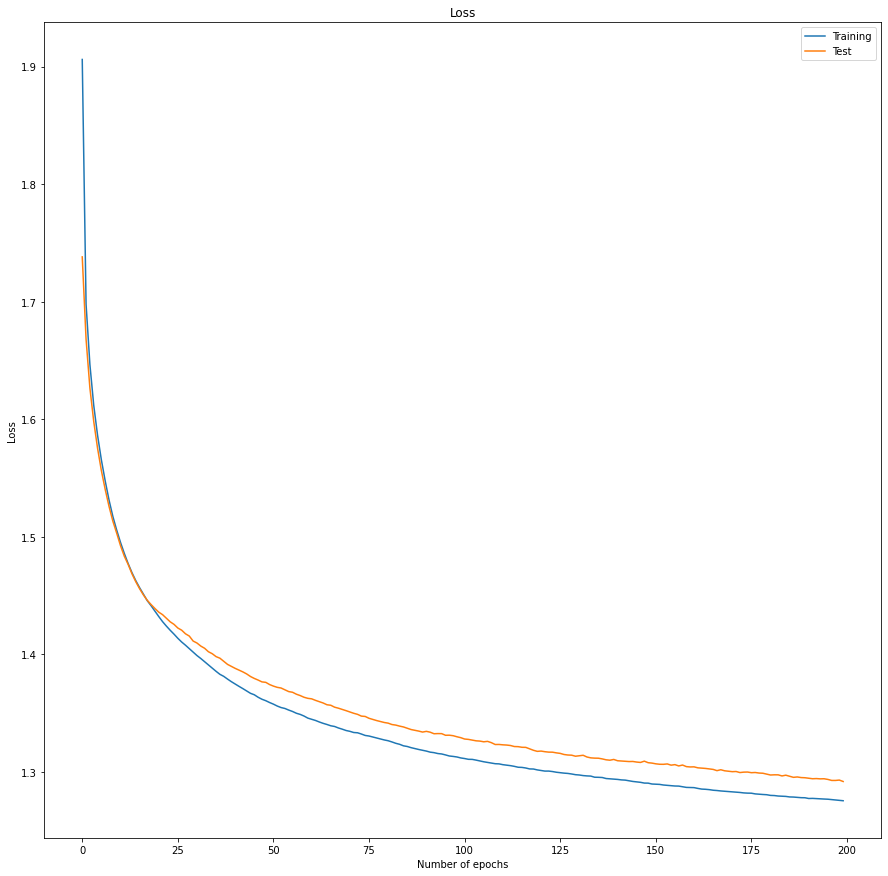

In [23]:
loss_storage = np.array([float(i) for i in loss_storage])
test_loss_storage = np.array([float(i) for i in test_loss_storage])
plt.figure(figsize= (15,15))
plt.plot(np.arange(len(loss_storage)), loss_storage, label = 'Training')
plt.plot(np.arange(len(test_loss_storage)), test_loss_storage, label = 'Test')
plt.title('Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualizing the Accuracy

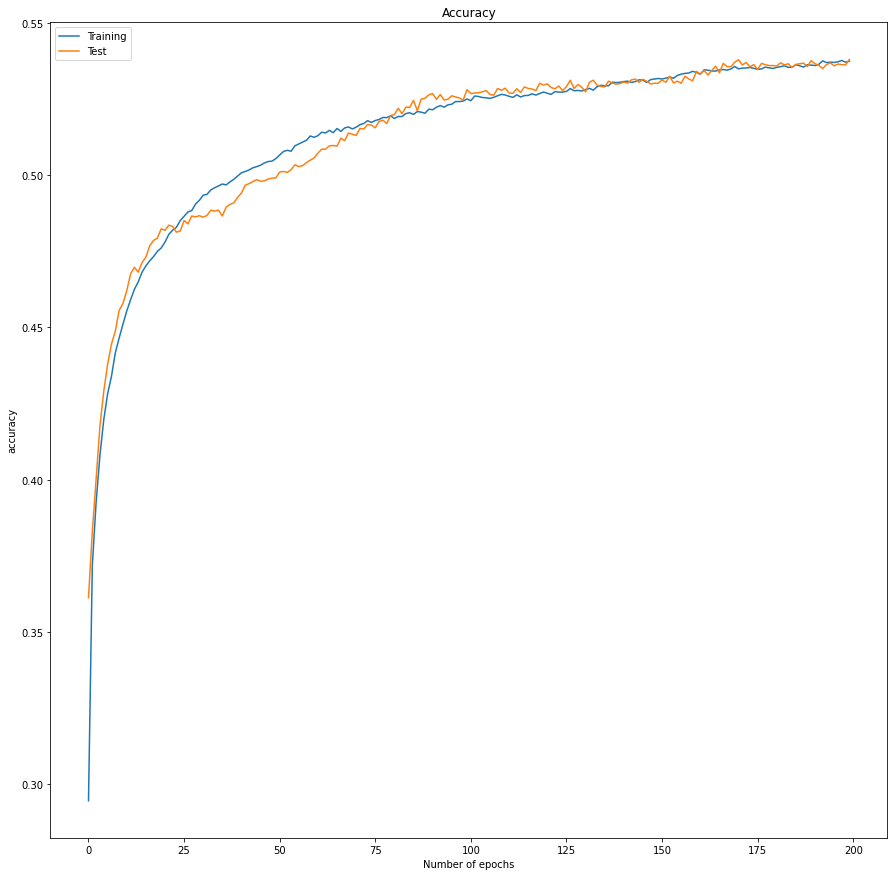

In [18]:
accuracy_storage = np.array([float(i) for i in accuracy_storage])
test_accuracy_storage = np.array([float(i) for i in test_accuracy_storage])
plt.figure(figsize= (15,15))
plt.plot(np.arange(len(accuracy_storage)), accuracy_storage, label = 'Training')
plt.plot(np.arange(len(test_accuracy_storage)), test_accuracy_storage, label = 'Test')
plt.title('Accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Test Loss and Accuracy

In [20]:
loss_test = 0
test_accuracy = 0
with torch.no_grad():
    for _ in range(0, test_x.shape[0], images_per_batch):
        y_hat = model(test_x[_:_+images_per_batch].cuda())
        y_actual = test_y[_:_+images_per_batch].cuda()
        loss = cross_entropy_loss(y_hat.view(y_actual.shape[0], -1), y_actual)
        loss_test += loss.item()
        pred = y_hat.view(y_actual.shape[0], -1).argmax(dim=1)
        test_accuracy += pred.eq(y_actual.view_as(pred)).sum().item() / y_actual.shape[0]
    
    mean_test_accuracy = test_accuracy/(test_x.shape[0]/images_per_batch)
    mean_test_loss = loss_test/(test_x.shape[0]/images_per_batch)

print('Loss: ', mean_test_loss)
print('Accuracy: ', mean_test_accuracy)

Loss:  1.252586187362671
Accuracy:  0.5454
